In [3]:
import ROOT
from ROOT import TFile
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import copy
import pandas as pd 
import time
from os import listdir

Welcome to JupyROOT 6.27/01


In [4]:
class particle:
    def __init__(self, pid, fourvector, Q2, Nu):
        #In the lab frame, but with the photon is aligned with z-direction, the photon has 4-momentum q= (0,0,sqrt(Nu2+Q2),Nu) (note q2 = -Q2)        
        self.virtual_photon = ROOT.TLorentzVector()
        self.virtual_photon.SetPxPyPzE(0,0,np.sqrt(Nu*Nu+Q2),Nu)
        self.virtual_photon_CM = self.virtual_photon
        self.proton = ROOT.TLorentzVector()
        self.proton.SetPxPyPzE(0,0,0, 0.938)
        self.proton_CM = self.proton
        
        Ebeam=5.0
        self.W = (self.virtual_photon + self.proton).M()
        incoming_e = ROOT.TLorentzVector()
        thetae = 2*np.arcsin(np.sqrt(Q2/(4*Ebeam*(Ebeam-Nu))))
        thetaq = np.arcsin((Ebeam-Nu)*np.sin(thetae)/np.sqrt(Nu*Nu+Q2))
        incoming_e.SetPxPyPzE(5.0*np.sin(thetaq),0,5.0*np.cos(thetaq),5.0)####INCONSISTENT
        part1 = self.virtual_photon.Vect().Cross(incoming_e.Vect()).Unit()
        part2 = self.virtual_photon.Vect().Cross(fourvector.Vect()).Unit()
        sign  = np.sign(part1.Dot(fourvector.Vect()))
        self.PhiPQ = sign*np.arccos(part1.Dot(part2))
        
        photon_pz = np.sqrt(Nu*Nu+Q2) #direction is positive by definition
        self.bcm = photon_pz/(Nu + 0.938)#photon-nucleon center-of-mass velocity 
        self.ycm = 0.5*np.log(( 1+self.bcm)/(1-self.bcm)) #photon-nucleon center-of-mass rapidity
        self.virtual_photon_CM.Boost(0.0,0.0,-self.bcm)
        self.proton_CM.Boost(0.0,0.0,-self.bcm)
        
        self.LorentzVector = fourvector #hadron four-vector
        self.PhiLab = self.LorentzVector.Phi()
        self.E = self.LorentzVector.E() #energy in lab frame
        self.vector = self.LorentzVector.Vect()
        self.Pt = self.vector.Perp(self.virtual_photon.Vect().Unit()) #pT with respect to photon direction
        self.Pl  = self.vector.Dot(self.virtual_photon.Vect().Unit()) #pL with respect to photon direction (in lab frame)
        self.y =  0.5*np.log( (self.E+self.Pl)/(self.E-self.Pl)) #rapidity in lab frame
        self.mT = np.sqrt(self.LorentzVector.M2() + self.Pt*self.Pt)
        self.mass = self.LorentzVector.M() 
        self.y_star = self.y - self.ycm
        self.Pl_star = self.mT*np.sinh(self.y_star)
        self.Pstar = np.sqrt(self.Pl_star*self.Pl_star + self.Pt*self.Pt)
        self.eta = np.arctanh(self.Pl_star/self.Pstar)
        #self.eta =  0.5*np.log( (self.Pstar+self.Pl_star)/(self.Pstar-self.Pl_star)) 
        
        self.Xf = 2.0*self.Pl_star/self.W 
        self.pid = pid
        self.Zh = self.E/Nu
        self.ThetaPQ = np.arctan(self.Pt/self.Pl)
        self.Xb = Q2/(2*0.938*Nu)
        self.ThetaLab = incoming_e.Vect().Angle(fourvector.Vect())

        #'phi =%2.2f'%self.PhiLab,
    def print_properties(self):
        #print ('Hello, let me introduce myself, i am particle pid = ' , self.pid)
        #print ('PID', self.pid, ' zh = %2.2f'%self.Zh,  'E = %2.2f'%self.E, 'phi =%2.2f'%self.PhiLab,'theta=%2.2f'%self.LorentzVector.Theta(),'pt %2.2f'%self.Pt)
        print ('PID', self.pid, ' pT = %2.2f'%self.Pt,  'Pl= %2.2f'%self.Pl_star, 'Xf=%2.2f'%self.Xf, 'Zh=%2.2f'%self.Zh, 'phi =%2.2f'%self.PhiLab)

        
        #print ('%2.3f,'%self.LorentzVector.Px(),'%2.3f,'%self.LorentzVector.Py(),'%2.3f,'%self.LorentzVector.Pz(), '%2.23f,'%self.LorentzVector.E())


In [5]:
class mytupla:
    def __init__(self):
        self.tupla = {}
        variables = ['dphi','dphi_lab','qt','drap','h1_z','h2_z','z_tot','h1_xf','h2_xf',
                     'h1_rap', 'ycm','h2_rap','h1_pid','h2_pid','h1_cm_ph','h2_cm_ph','h1_cm_pt','h2_cm_pt',
                      'h1_cm_th','h2_cm_th','pair_mass','pair_pt','mx_eh1h2',
                      'Q2','x','nu','W','h1_ph','h1_th','h2_ph','h2_th',
                       'pos_x', 'pos_y','pos_z','pos_x_asso', 'pos_y_asso','pos_z_asso']
        
        for var in variables:
            self.tupla[var] = []
        
        trigger_variables = ['h1_pid','h1_xf','h1_z','h1_rap','ycm','h1_pt','Q2','x','nu','W','h1_cm_ph','h1_cm_th','h1_cm_pt','mass', 'pstar','plstar','eta',
                             'TargType','h1_ph','h1_th','pos_x','pos_y','pos_z']
        
        self.tupla_hadron = {}
        for var in trigger_variables:
            self.tupla_hadron[var] = []    

In [6]:

def getDataframes(filename, Target=1,maxevents=1e9,beamenergy=5.0):
    dphi = np.array([])
    ParticlesFromPrevious = []
    try:
        myfile = TFile.Open('%s'%filename,'READ')
    except:
        print("could not open file")

        
    myfile.Print()
    mytree = myfile.Get('RootTuple')
    
    print (filename, ' has ', mytree.GetEntries(), ' entries')
    print ('The max number of events to be analyzes is ', maxevents)
    df = mytupla()    
    
    start = time.time()
    for ievt  in range(mytree.GetEntries()):
        if(ievt%1e5==0):
            print ('Event # ', ievt)
            end = time.time()
            print ('Processed in',  end-start, 'seconds')
            start = time.time()
        mytree.GetEntry(ievt)   
        if mytree.Q2<1.0: continue
        if ievt>maxevents: break
        Nu = mytree.nu
        Q2 = mytree.Q2
        phi_e = mytree.phiL 
        E    = beamenergy
        Eprime = E-Nu
        
        incoming_e = ROOT.TLorentzVector()
        incoming_e.SetPxPyPzE(0,0,E,E)
        
        #scattered electron
        scattered_e = ROOT.TLorentzVector()
        cos_thetae = 1-Q2/(2*E*Eprime)
        sin_thetae = np.sqrt(1-cos_thetae*cos_thetae)
        scattered_e.SetPxPyPzE(Eprime*sin_thetae*np.cos(phi_e),
                               Eprime*sin_thetae*np.sin(phi_e),
                               Eprime*cos_thetae,
                               Eprime)
        virtual_photon  = incoming_e - scattered_e
        virtual_photon_unitvector = virtual_photon.Vect().Unit()

        proton = ROOT.TLorentzVector()
        proton.SetPxPyPzE(0,0,0, 0.938)
        #print virtual_photon.M2(), ' ' , Q2
        #print virtual_photon.Vect().Mag(), ' ' , np.sqrt(Nu*Nu+Q2*Q2)
        
        #virtual_photon = ROOT.TLorentzVector()
        #virtual_photon.SetPxPyPzE( 0, 0, np.sqrt(Nu*Nu+Q2*Q2),Nu)  #lab frame but with z in photon direction 
        #cos_thetaphoton = E -Eprime
        
        #need to rotate to lab frame with z aligned with beam frame
        #virtual_photon.Rotate()
        #### virtual photon 
        #electron in lab frame = (0,0,E,E)
        #scattered electron in lab frame = (E'sintheta*cosphi,E'sintheta'sinphi,E'costheta,E')
        
        #Q2= 2EE'(1-cos_thetae)
        # cos_thetae =1- Q2/2EE'

        #photon in lab frame is e-e'
        # (-E'sintheta*cosphi, -E'sintheta*sinphi, E-E'costheta, E-E')
        
        #cos_thetaphoton = (E- E'*costheta)/(E-E')
        #cos_thetaphoton = (E- E'*(1- Q2/2EE'))/(E-E')
        #sin_thetaphoton = sqrt(1-cos_thetaphoton*cos_thetaphoton)
        #Thus, photon pT in lab frame with z-lepton direction is:
        #pT = E'sqrt(1-cos_thetaphoton^{2})
        #pT = E'sqrt(1- (E- E'*(1- Q2/2EE'))/(E-E')^{2} )
        #and finally, photon phi angle is:
        # phi_photon = -phi_electron (given)
      
        for i in range(len(mytree.Px)):
            if abs(mytree.barcode[i]) !=211: continue
            i_lv = ROOT.TLorentzVector()    
            i_lv.SetPxPyPzE(mytree.Px[i],mytree.Py[i],mytree.Pz[i],mytree.E[i]) #with respect to photon direction
            i_part = particle(mytree.barcode[i], i_lv, Q2, Nu)
            if i_part.Zh > 0.5:
                df.tupla_hadron['TargType'].append(999)
                df.tupla_hadron['h1_pid'].append(i_part.pid)
                df.tupla_hadron['h1_xf'].append(i_part.Xf)
                df.tupla_hadron['h1_z'].append(i_part.Zh)
                df.tupla_hadron['h1_rap'].append(i_part.y_star)
                df.tupla_hadron['ycm'].append(i_part.ycm)
                df.tupla_hadron['h1_pt'].append(i_part.LorentzVector.Pt())
                df.tupla_hadron['h1_ph'].append(i_part.PhiPQ)
                df.tupla_hadron['h1_th'].append(i_part.ThetaLab)
                df.tupla_hadron['Q2'].append(Q2)
                df.tupla_hadron['x'].append(i_part.Xb)
                df.tupla_hadron['nu'].append(Nu)
                df.tupla_hadron['W'].append(i_part.W)
                df.tupla_hadron['h1_cm_ph'].append(i_part.LorentzVector.Phi())
            
                df.tupla_hadron['h1_cm_th'].append(i_part.LorentzVector.Theta())
                df.tupla_hadron['h1_cm_pt'].append(i_part.LorentzVector.Pt())
                df.tupla_hadron['mass'].append(i_part.mass)
                df.tupla_hadron['eta'].append(i_part.eta)
                df.tupla_hadron['pstar'].append(i_part.Pstar)
                df.tupla_hadron['plstar'].append(i_part.Pl_star)

                df.tupla_hadron['pos_x'].append(mytree.x[i])
                df.tupla_hadron['pos_y'].append(mytree.y[i])
                df.tupla_hadron['pos_z'].append(mytree.z[i])
                
                for j in range(len(mytree.Px)): 
                    if i==j: continue
                    if abs(mytree.barcode[j]) !=211 and mytree.barcode[j]!=2212: continue
                    j_lv = ROOT.TLorentzVector()    
                    j_lv.SetPxPyPzE(mytree.Px[j],mytree.Py[j],mytree.Pz[j],mytree.E[j])
                    j_part = particle(mytree.barcode[j], j_lv, Q2, Nu)
                    
                    dphi = abs(ROOT.TVector2.Phi_mpi_pi(i_part.PhiPQ-j_part.PhiPQ))
                    dphi_lab = abs(ROOT.TVector2.Phi_mpi_pi(i_part.PhiLab-j_part.PhiLab))
                    dipion = i_part.LorentzVector+j_part.LorentzVector
                    qt = dipion.Pt()
                    X = (virtual_photon + proton - dipion) #unobserved hadronic system

                    
            
                    
                    df.tupla['dphi_lab'].append(dphi)
                    df.tupla['dphi'].append(dphi_lab)
                    df.tupla['qt'].append(qt)
                    df.tupla['drap'].append(i_part.y_star-j_part.y_star)
                    df.tupla['h1_z'].append(i_part.Zh)
                    df.tupla['h2_z'].append(j_part.Zh)
                    df.tupla['z_tot'].append(i_part.Zh+j_part.Zh)
                    df.tupla['h1_xf'].append(i_part.Xf)
                    df.tupla['h2_xf'].append(j_part.Xf)
                    df.tupla['h1_rap'].append(i_part.y_star)
                    df.tupla['ycm'].append(i_part.ycm)
                    df.tupla['h2_rap'].append(j_part.y_star)
                    df.tupla['h1_pid'].append(i_part.pid)
                    df.tupla['h2_pid'].append(j_part.pid)
                    df.tupla['h1_ph'].append(i_part.PhiPQ)
                    df.tupla['h2_ph'].append(j_part.PhiPQ)
                    df.tupla['h1_th'].append(i_part.ThetaLab)
                    df.tupla['h2_th'].append(j_part.ThetaLab)
                    df.tupla['pair_mass'].append(dipion.M())
                    df.tupla['pair_pt'].append( dipion.Pt())
                    df.tupla['mx_eh1h2'].append(X.M())
                    df.tupla['Q2'].append(Q2)
                    df.tupla['x'].append(i_part.Xb)
                    df.tupla['nu'].append(Nu)
                    df.tupla['W'].append(i_part.W)
                    df.tupla['h1_cm_ph'].append(i_part.LorentzVector.Phi())
                    df.tupla['h1_cm_th'].append(i_part.LorentzVector.Theta())
                    df.tupla['h1_cm_pt'].append(i_part.LorentzVector.Pt())
                    df.tupla['h2_cm_ph'].append(j_part.LorentzVector.Phi())
                    df.tupla['h2_cm_th'].append(j_part.LorentzVector.Theta())
                    df.tupla['h2_cm_pt'].append(j_part.LorentzVector.Pt())
                    df.tupla['pos_x'].append(mytree.x[i])
                    df.tupla['pos_y'].append(mytree.y[i])
                    df.tupla['pos_z'].append(mytree.z[i])
                    df.tupla['pos_x_asso'].append(mytree.x[j])
                    df.tupla['pos_y_asso'].append(mytree.y[j])
                    df.tupla['pos_z_asso'].append(mytree.z[j])
        
        
    end = time.time()
    print ('Processed in',  end-start, 'seconds')
    df_pair = pd.DataFrame(df.tupla)
    df_hadron = pd.DataFrame(df.tupla_hadron)
    return df_pair, df_hadron

In [12]:
df = {}
import gc
gc.collect()

464

## Configuration for CLAS12

In [19]:
path = '/home/miguel/GiBUU/'
import root_pandas

/home/sebouh/.local/lib/python3.8/site-packages/uproot3/__init__.py:127: FutureWarning: Consider switching from 'uproot3' to 'uproot', since the new interface became the default in 2020.

    pip install -U uproot

In Python:

    >>> import uproot
    >>> with uproot.open(...) as file:
    ...

  warnings.warn(
/home/sebouh/.local/lib/python3.8/site-packages/awkward0/__init__.py:12: FutureWarning: Consider switching from 'awkward0' to 'awkward', since the new interface became the default in 2020.

    pip install -U awkward

In Python:

    >>> import awkward as ak
    >>> new_style_array = ak.from_awkward0(old_style_array)
    >>> old_style_array = ak.to_awkward0(new_style_array)

  warnings.warn(


In [20]:
%%time
def process(a):
    df={}
    df[a], df[f'{a}_trigger'] = getDataframes(path+f'GiBUU_{a}.root',maxevents=1e7)

    root_pandas.to_root_multi(f'GiBUU_Pairs_{a}.root',
                              {a:df[a],f'{a}_trigger':df[f'{a}_trigger']})
for a in 'D C Fe Pb'.split():
    process(a)

# import time
# import ipyparallel as ipp

# task_durations = [1] * 25
# # request a cluster
# with ipp.Cluster() as rc:
#     #help(rc)
#     # get a view on the cluster
#     view = rc.load_balanced_view()
#     # submit the tasks
#     asyncresult = view.map_async(process, "D C Fe Pb".split())
#     # wait interactively for results
#     asyncresult.wait()
#     # retrieve actual results
#     result = asyncresult.get()


#for a in 'D C Fe Pb'.split():
#    df[a], df[f'{a}_trigger'] = getDataframes(path+f'GiBUU_{a}.root',maxevents=1e7)

#    root_pandas.to_root_multi(f'GiBUU_Pairs_{a}.root',
#                              {a:df[a],f'{a}_trigger':df[f'{a}_trigger']})

/home/miguel/GiBUU/GiBUU_D.root  has  8363332  entries
The max number of events to be analyzes is  10000000.0
Event #  0
Processed in 3.886222839355469e-05 seconds
Event #  100000
Processed in 13.951163291931152 seconds
Event #  200000
Processed in 14.14913535118103 seconds
Event #  300000
Processed in 14.276500940322876 seconds
Event #  400000
Processed in 14.27879810333252 seconds
Event #  500000
Processed in 14.437160730361938 seconds
Event #  600000
Processed in 14.384119272232056 seconds
Event #  700000
Processed in 14.356348276138306 seconds
Event #  800000
Processed in 14.383131980895996 seconds
Event #  900000
Processed in 14.205484867095947 seconds
Event #  1000000
Processed in 14.38512372970581 seconds
Event #  1100000
Processed in 14.311851024627686 seconds
Event #  1200000
Processed in 14.096556901931763 seconds
Event #  1300000
Processed in 13.991549253463745 seconds
Event #  1400000
Processed in 14.251023054122925 seconds
Event #  1500000
Processed in 14.26660966873169 se

Event #  5700000
Processed in 14.398118019104004 seconds
Event #  5800000
Processed in 14.82847261428833 seconds
Event #  5900000
Processed in 14.940165281295776 seconds
Event #  6000000
Processed in 14.958308935165405 seconds
Event #  6100000
Processed in 14.823605060577393 seconds
Event #  6200000
Processed in 14.773799419403076 seconds
Event #  6300000
Processed in 14.796133756637573 seconds
Event #  6400000
Processed in 14.857040405273438 seconds
Event #  6500000
Processed in 14.890189409255981 seconds
Event #  6600000
Processed in 14.762588500976562 seconds
Event #  6700000
Processed in 14.81070590019226 seconds
Event #  6800000
Processed in 14.634869813919067 seconds
Event #  6900000
Processed in 14.912609338760376 seconds
Event #  7000000
Processed in 14.944846391677856 seconds
Event #  7100000
Processed in 14.828585624694824 seconds
Event #  7200000
Processed in 14.921262741088867 seconds
Event #  7300000
Processed in 14.919508218765259 seconds
Event #  7400000
Processed in 14.

Exception ignored in: <function tqdm.__del__ at 0x7efcf8154430>
Traceback (most recent call last):
  File "/home/sebouh/.local/lib/python3.8/site-packages/tqdm/std.py", line 1162, in __del__
    self.close()
  File "/home/sebouh/.local/lib/python3.8/site-packages/tqdm/notebook.py", line 287, in close
    self.disp(bar_style='danger', check_delay=False)
  File "/home/sebouh/.local/lib/python3.8/site-packages/tqdm/notebook.py", line 160, in display
    d = self.format_dict
  File "/home/sebouh/.local/lib/python3.8/site-packages/tqdm/std.py", line 1476, in format_dict
    'colour': self.colour}
  File "/home/sebouh/.local/lib/python3.8/site-packages/tqdm/notebook.py", line 203, in colour
    return self.container.children[-2].style.bar_color
AttributeError: 'FloatProgress' object has no attribute 'style'
Exception ignored in: <function tqdm.__del__ at 0x7efcf8154430>
Traceback (most recent call last):
  File "/home/sebouh/.local/lib/python3.8/site-packages/tqdm/std.py", line 1162, in __de

/home/miguel/GiBUU/GiBUU_Fe.root  has  5596315  entries
The max number of events to be analyzes is  10000000.0
Event #  0
Processed in 0.0008056163787841797 seconds
Event #  100000
Processed in 14.889602184295654 seconds
Event #  200000
Processed in 14.882904291152954 seconds
Event #  300000
Processed in 14.831164598464966 seconds
Event #  400000
Processed in 14.853370428085327 seconds
Event #  500000
Processed in 15.115745544433594 seconds
Event #  600000
Processed in 15.081565141677856 seconds
Event #  700000
Processed in 14.846678495407104 seconds
Event #  800000
Processed in 14.746846199035645 seconds
Event #  900000
Processed in 15.011005640029907 seconds
Event #  1000000
Processed in 14.741187572479248 seconds
Event #  1100000
Processed in 14.6093168258667 seconds
Event #  1200000
Processed in 14.848507404327393 seconds
Event #  1300000
Processed in 14.716190814971924 seconds
Event #  1400000
Processed in 14.867201328277588 seconds
Event #  1500000
Processed in 14.895457983016968

CPU times: user 1h 23min 37s, sys: 6min 24s, total: 1h 30min 1s
Wall time: 1h 21min 38s
TFile: name=/home/miguel/GiBUU/GiBUU_D.root, title=, option=READ
TFile: name=/home/miguel/GiBUU/GiBUU_C.root, title=, option=READ
TFile: name=/home/miguel/GiBUU/GiBUU_Fe.root, title=, option=READ
TFile: name=/home/miguel/GiBUU/GiBUU_Pb.root, title=, option=READ


In [8]:
%%time
df['C'], df['C_trigger'] = getDataframes(path+'GiBUU_C.root',maxevents=1e7)

/home/miguel/GiBUU/GiBUU_C.root  has  21776066  entries
The max number of events to be analyzes is  10000000.0
Event #  0
Processed in 3.5762786865234375e-05 seconds
Event #  100000
Processed in 13.29509425163269 seconds
Event #  200000
Processed in 13.26983642578125 seconds
Event #  300000
Processed in 13.365793466567993 seconds
Event #  400000
Processed in 13.372714519500732 seconds
Event #  500000
Processed in 13.323720455169678 seconds
Event #  600000
Processed in 13.213054895401001 seconds
Event #  700000
Processed in 13.474785089492798 seconds
Event #  800000
Processed in 13.3814857006073 seconds
Event #  900000
Processed in 13.233702182769775 seconds
Event #  1000000
Processed in 13.229768514633179 seconds
Event #  1100000
Processed in 13.281393051147461 seconds
Event #  1200000
Processed in 13.307044744491577 seconds
Event #  1300000
Processed in 13.363019227981567 seconds
Event #  1400000
Processed in 13.318228483200073 seconds
Event #  1500000
Processed in 13.29827070236206 s

In [ ]:
%%time
df['Fe'], df['Fe_trigger'] = getDataframes(path+'GiBUU_Fe.root',maxevents=1e7)

/home/miguel/GiBUU/GiBUU_Fe.root  has  5596315  entries
The max number of events to be analyzes is  10000000.0
Event #  0
Processed in 3.24249267578125e-05 seconds
Event #  100000
Processed in 13.42441701889038 seconds
Event #  200000
Processed in 13.413690090179443 seconds
Event #  300000
Processed in 13.37452220916748 seconds
Event #  400000
Processed in 13.43957781791687 seconds
Event #  500000
Processed in 13.429415702819824 seconds
Event #  600000
Processed in 13.417776823043823 seconds
Event #  700000
Processed in 13.3951997756958 seconds
Event #  800000
Processed in 13.432294130325317 seconds
Event #  900000
Processed in 13.438811540603638 seconds
Event #  1000000
Processed in 13.389996767044067 seconds
Event #  1100000
Processed in 13.398212194442749 seconds
Event #  1200000
Processed in 13.369481086730957 seconds
Event #  1300000
Processed in 13.409316301345825 seconds
Event #  1400000
Processed in 13.411759376525879 seconds
Event #  1500000
Processed in 13.449874877929688 sec

In [16]:
%%time
df['Pb'], df['Pb_trigger'] = getDataframes(path+'GiBUU_Pb.root',maxevents=1e7)

/home/miguel/GiBUU/GiBUU_Pb.root  has  8315826  entries
The max number of events to be analyzes is  10000000.0
Event #  0
Processed in 0.00017523765563964844 seconds
Event #  100000
Processed in 13.164879083633423 seconds
Event #  200000
Processed in 13.060327053070068 seconds
Event #  300000
Processed in 13.243153095245361 seconds
Event #  400000
Processed in 13.171844005584717 seconds
Event #  500000
Processed in 13.08111310005188 seconds
Event #  600000
Processed in 13.318179368972778 seconds
Event #  700000
Processed in 13.33277702331543 seconds
Event #  800000
Processed in 13.245036363601685 seconds
Event #  900000
Processed in 12.998645544052124 seconds
Event #  1000000
Processed in 13.238137483596802 seconds
Event #  1100000
Processed in 13.037312030792236 seconds
Event #  1200000
Processed in 13.210913181304932 seconds
Event #  1300000
Processed in 13.17081880569458 seconds
Event #  1400000
Processed in 13.544397115707397 seconds
Event #  1500000
Processed in 13.559772968292236

KeyboardInterrupt: 

TFile: name=/home/miguel/GiBUU/GiBUU_Pb.root, title=, option=READ


In [ ]:
import root_pandas
from root_pandas import read_root
from root_pandas import to_root 

In [ ]:
print (df['Pb'].shape[0])
print (df['Pb_trigger'].shape[0])

In [ ]:
print (df['D'].shape[0])
print (df['D_trigger'].shape[0])

<module 'root_pandas' from '/home/sebouh/di-hadron/root_pandas.py'>

## Save dataframes to ROOT files

In [15]:
for a in 'D C Fe Pb'.split():
    root_pandas.to_root_multi(f'GiBUU_Pairs_{a}.root',
                          {a:df[a],f'{a}_trigger':df[f'{a}_trigger']})
    print(a)


Help on module root_pandas:

NAME
    root_pandas

FUNCTIONS
    read_root(filename, treename=None, N=None)
    
    to_root(df, filename, treename)
        #create single-tree root file
    
    to_root_multi(filename, d)
        #create root file with multiple trees:
        # d is a map of tree name to data frames {"tree1":df1, "tree2":df2 ... etc}

FILE
    /home/sebouh/di-hadron/root_pandas.py


D
C
Fe


KeyError: 'Pb'

In [ ]:
to_root(df['C'],'GiBUU_Pairs_C.root', key='C')
to_root(df['C_trigger'],'GiBUU_Pairs_C.root', key='C_trigger', mode='a')

In [ ]:
to_root(df['Fe'],'GiBUU_Pairs_Fe.root', key='Fe')
to_root(df['Fe_trigger'],'GiBUU_Pairs_Fe.root', key='Fe_trigger', mode='a')

In [22]:
to_root(df['Pb'],'GiBUU_Pairs_Pb.root', key='Pb')
to_root(df['Pb_trigger'],'GiBUU_Pairs_Pb.root', key='Pb_trigger', mode='a')

NameError: name 'to_root' is not defined

In [ ]:
%%time
for a in "D C Fe Pb".split():
    df ={}
    df[f'{a}'], df[f'{a}_trigger'] = getDataframes(f'tweak/{a}_tweak.root',maxevents=1e7)
    root_pandas.to_root_multi(f'GiBUU_Pairs_{a}_tweak.root',df)
#to_root(df['D'],'GiBUU_Pairs_D_tweak.root', key='D')
#to_root(df['D_trigger'],'GiBUU_Pairs_D_tweak.root', key='D_trigger', mode='a')

tweak/D_tweak.root  has  9537138  entries
The max number of events to be analyzes is  10000000.0
Event #  0
Processed in 0.0007219314575195312 seconds
Event #  100000
Processed in 14.803261518478394 seconds
Event #  200000
Processed in 14.572305917739868 seconds
Event #  300000
Processed in 14.785316467285156 seconds
Event #  400000
Processed in 14.705440521240234 seconds
Event #  500000
Processed in 14.719735145568848 seconds
Event #  600000
Processed in 14.629900932312012 seconds
Event #  700000
Processed in 14.542781591415405 seconds
Event #  800000
Processed in 14.67541766166687 seconds
Event #  900000
Processed in 14.607827186584473 seconds
Event #  1000000
Processed in 14.488741159439087 seconds
Event #  1100000
Processed in 14.578198194503784 seconds
Event #  1200000
Processed in 14.747605800628662 seconds
Event #  1300000
Processed in 14.60577654838562 seconds
Event #  1400000
Processed in 14.609979391098022 seconds
Event #  1500000
Processed in 14.673862934112549 seconds
Event

Event #  4500000
Processed in 15.123923778533936 seconds
Event #  4600000
Processed in 15.26902985572815 seconds
Event #  4700000
Processed in 14.855867624282837 seconds
Event #  4800000
Processed in 14.889046669006348 seconds
Event #  4900000
Processed in 15.093396186828613 seconds
Event #  5000000
Processed in 14.866777420043945 seconds
Event #  5100000
Processed in 14.71361494064331 seconds
Event #  5200000
Processed in 14.733925580978394 seconds
Event #  5300000
Processed in 14.778270244598389 seconds
Event #  5400000
Processed in 14.962889671325684 seconds
Event #  5500000
Processed in 15.18518328666687 seconds
Event #  5600000
Processed in 15.010716199874878 seconds


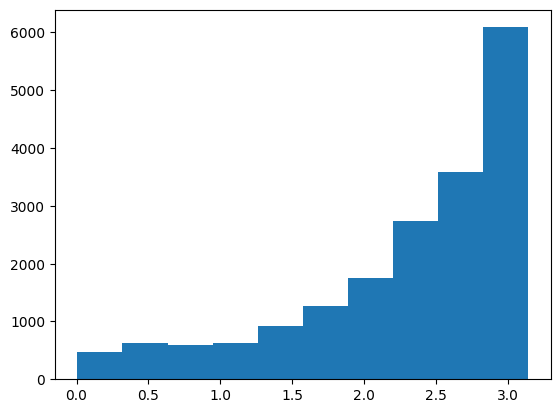

In [16]:
plt.hist(df['D'].query("h1_cm_pt>.25").dphi)
plt.show()

In [ ]:
## HERMES

In [ ]:
# to_root(df['D'],'GiBUU_Pairs_HERMES_D.root', key='D')
# to_root(df['D_trigger'],'GiBUU_Pairs_HERMES_D.root', key='D_trigger', mode='a')
# to_root(df['Kr'],'GiBUU_Pairs_HERMES_Kr.root', key='Kr')
# to_root(df['Kr_trigger'],'GiBUU_Pairs_HERMES_Kr.root', key='Kr_trigger', mode='a')

In [ ]:
# to_root(df['Xe'],'GiBUU_Pairs_HERMES_Xe.root', key='Xe')
# to_root(df['Xe_trigger'],'GiBUU_Pairs_HERMES_Xe.root', key='Xe_trigger', mode='a')

## CLAS12

In [ ]:
# to_root(df['D'],'GiBUU_Pairs_CLAS12_D.root', key='D')
# to_root(df['D_trigger'],'GiBUU_Pairs_CLAS12_D.root', key='D_trigger', mode='a')
# to_root(df['Pb'],'GiBUU_Pairs_CLAS12_Pb.root', key='Pb')
# to_root(df['Pb_trigger'],'GiBUU_Pairs_CLAS12_Pb.root', key='Pb_trigger', mode='a')

## Check dataframes variables

In [23]:
df['D']['dphi']

KeyError: 'D'

In [20]:
df['D'].keys()

Index(['dphi', 'dphi_lab', 'qt', 'drap', 'h1_z', 'h2_z', 'z_tot', 'h1_xf',
       'h2_xf', 'h1_rap', 'ycm', 'h2_rap', 'h1_pid', 'h2_pid', 'h1_cm_ph',
       'h2_cm_ph', 'h1_cm_th', 'h2_cm_th', 'pair_mass', 'pair_pt', 'mx_eh1h2',
       'Q2', 'x', 'nu', 'W', 'h1_ph', 'h1_th', 'h2_ph', 'h2_th', 'pos_x',
       'pos_y', 'pos_z', 'pos_x_asso', 'pos_y_asso', 'pos_z_asso'],
      dtype='object')

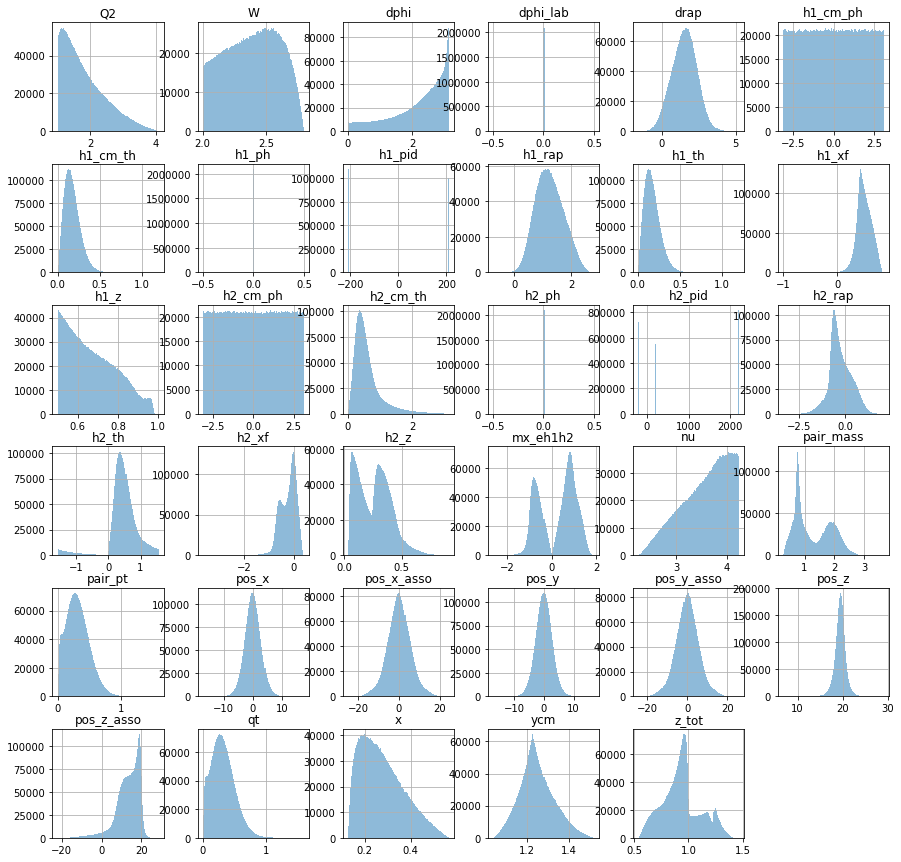

In [21]:
df['D'].query('h1_z>0.5').hist(figsize=(15, 15),alpha=0.5,bins=100)
plt.show()

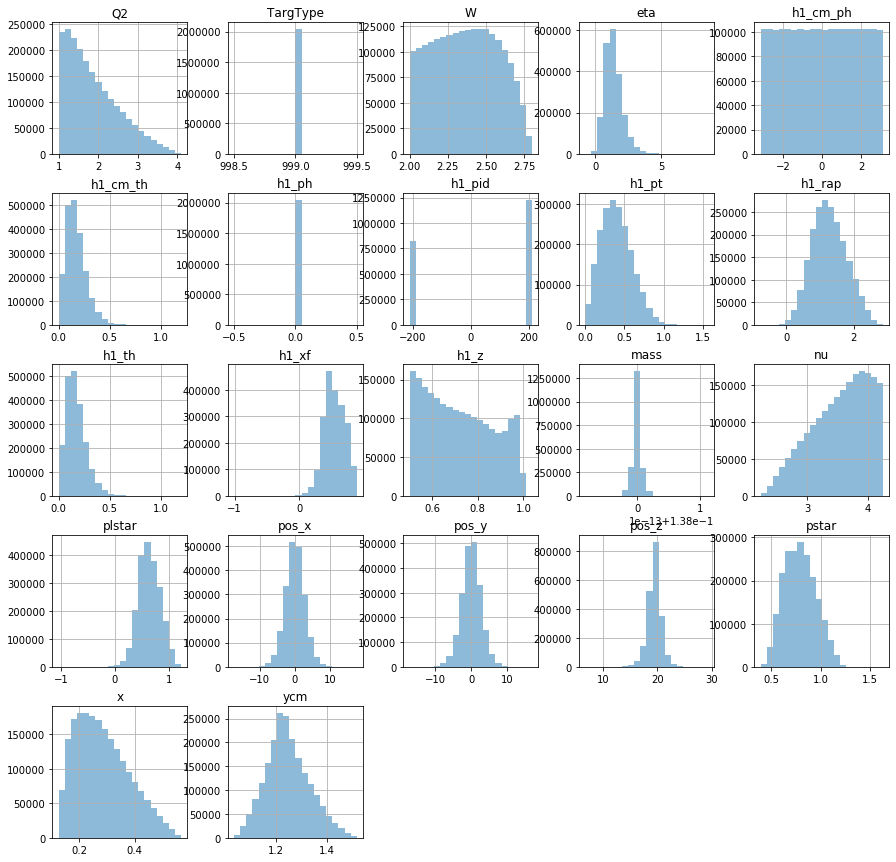

In [22]:
df['D_trigger'].hist(figsize=(15, 15),alpha=0.5,bins=20)
plt.show()

/usr/lib/python3/dist-packages/pandas/plotting/_matplotlib/hist.py:412: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax.hist(data[col].dropna().values, bins=bins, **kwds)


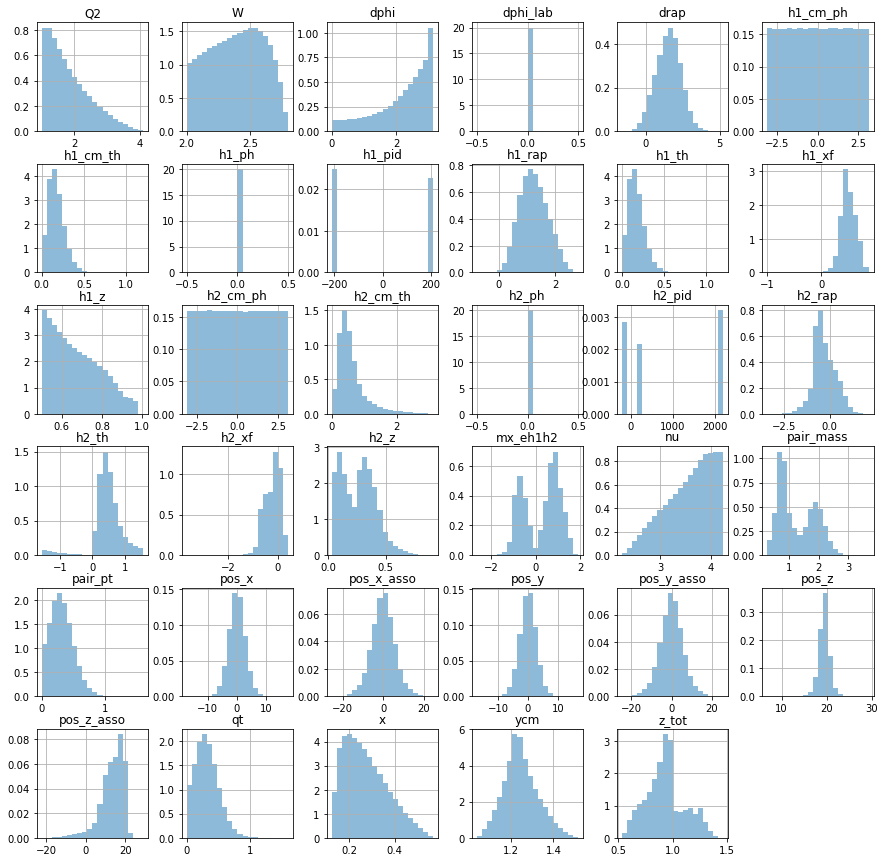

In [23]:
df['D'].hist(figsize=(15, 15),normed=True,alpha=0.5,bins=20)
plt.show()

In [26]:
df['D']['h2_pid']

0          -211
1          2212
2           211
3           211
4          -211
           ... 
2099625    2212
2099626    2212
2099627    2212
2099628    2212
2099629    -211
Name: h2_pid, Length: 2099630, dtype: int64

<ipython-input-24-3bb06a02a3ba>:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  y_D, x , _  = plt.hist(df['D']['h2_z'],bins=100,normed=True,alpha=0.7,label='D')
<ipython-input-24-3bb06a02a3ba>:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  y_C, x , _  = plt.hist(df['Pb']['h2_z'],bins=100,normed=True,alpha=0.7,label='C')


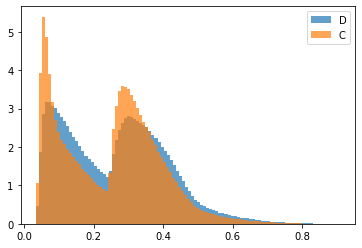

In [24]:
y_D, x , _  = plt.hist(df['D']['h2_z'],bins=100,normed=True,alpha=0.7,label='D')
y_C, x , _  = plt.hist(df['Pb']['h2_z'],bins=100,normed=True,alpha=0.7,label='C')
x = (x[1:] + x[:-1])/2.0
plt.legend()
plt.show()

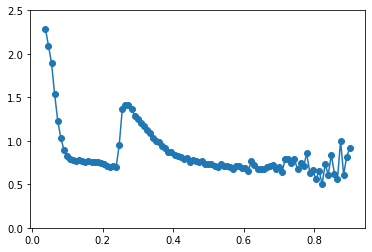

In [25]:
ratio = np.divide(y_C, y_D)
plt.errorbar(x, ratio, marker='o')

plt.ylim([0.0,2.5])
plt.show()

## Broadening